# Flight Delay Classification using Weather Data
**Author:** Ezgi Korkut

**Course:** DSA210 Term Project - Spring 2025

## Step 1: Introduction
This notebook presents the machine learning (ML) analysis stage of the project on predicting whether a flight will be delayed
by more than 15 minutes using weather data. This is framed as a binary classification problem.

**We apply two classification models:**
- Logistic Regression
- Random Forest Classifier

We evaluate their performance with cross-validation F1 scores and test-set metrics including accuracy and F1 score.

In [29]:
# Step 2: Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [30]:
# Step 3: Load and Prepare Data

def prepare_classification_data(path):
    df = pd.read_csv(path)
    df['Scheduled_datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Scheduled departure time'],
                                              format='%m/%d/%Y %H:%M', errors='coerce')
    df['dep_hour'] = df['Scheduled_datetime'].dt.hour
    df = df.dropna(subset=['Departure delay (Minutes)'])
    df['delayed'] = (df['Departure delay (Minutes)'] > 15).astype(int)
    feature_cols = ['dep_hour', 'AWND', 'PRCP', 'SNOW', 'TAVG', 'WSF2']
    X = df[feature_cols].fillna(0)
    y = df['delayed']
    return X, y, feature_cols

X, y, feature_names = prepare_classification_data("merged_flight_weather_Jan2023 (1).csv")

In [31]:
# Step 4: Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [32]:
# Step 5: Define and Train Classification Models

def build_classification_models(X_train, y_train):
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
    }

    results = {}
    for name, model in models.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])

        print(f"\n🔎 CLASSIFICATION: {name.upper()}")
        cv_f1 = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1_weighted')
        print(f"🌀 CV F1 Scores: {np.round(cv_f1, 3)} | Avg: {np.mean(cv_f1).round(3)}")
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        print(f"✅ Accuracy: {round(acc, 3)}")
        print(f"✅ F1 Score: {round(f1, 3)}")
        results[name] = {
            'model': pipeline,
            'cv_f1': cv_f1,
            'test_accuracy': acc,
            'test_f1': f1,
            'y_pred': y_pred
        }
    return results

classification_results = build_classification_models(X_train, y_train)


🔎 CLASSIFICATION: RANDOM FOREST
🌀 CV F1 Scores: [0.643 0.674 0.693 0.656 0.671] | Avg: 0.667
✅ Accuracy: 0.717
✅ F1 Score: 0.649

🔎 CLASSIFICATION: LOGISTIC REGRESSION
🌀 CV F1 Scores: [0.606 0.606 0.606 0.606 0.608] | Avg: 0.606
✅ Accuracy: 0.723
✅ F1 Score: 0.607


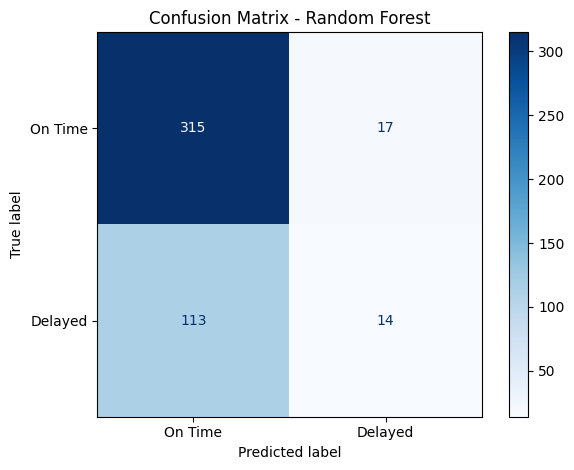

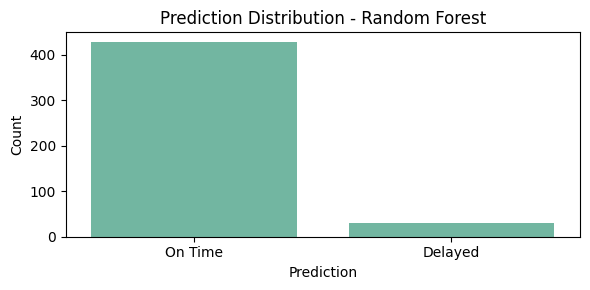

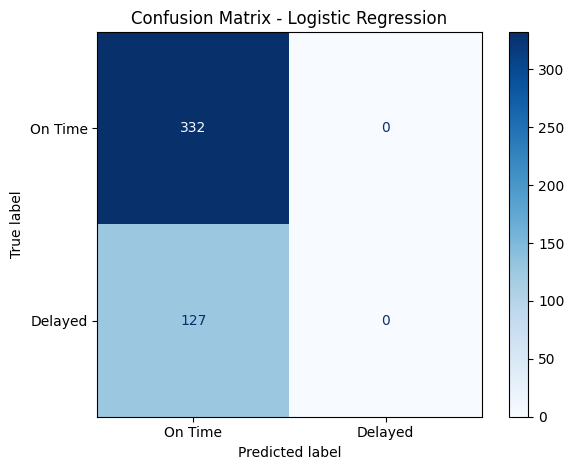

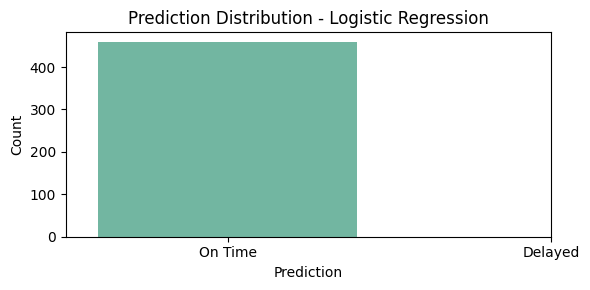

In [33]:
# Step 6: Confusion Matrices and Prediction Distribution

for name, result in classification_results.items():
    y_pred = result['y_pred']

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['On Time', 'Delayed'])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()

    # ✅ Fully compatible countplot
    plt.figure(figsize=(6, 3))
    df_pred = pd.DataFrame({'Prediction': y_pred})
    sns.countplot(data=df_pred, x='Prediction', color=sns.color_palette('Set2')[0])
    plt.xticks([0, 1], ['On Time', 'Delayed'])
    plt.title(f"Prediction Distribution - {name}")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


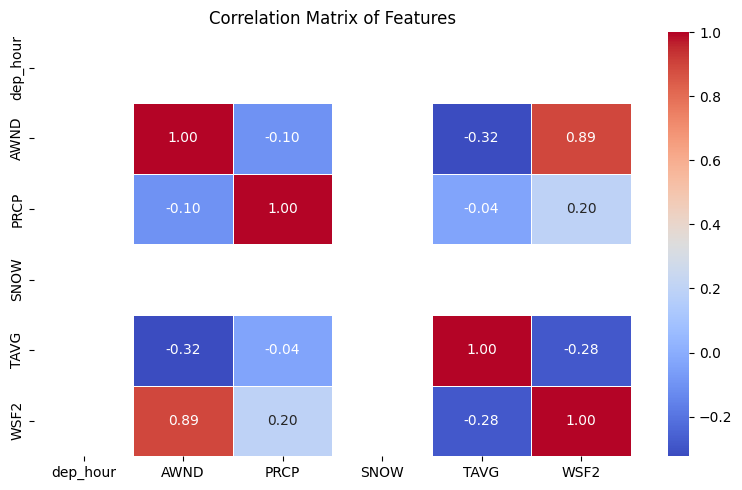

In [25]:
# Correlation heatmap
plt.figure(figsize=(8, 5))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.tight_layout()
plt.show()

In [34]:

# Step 7: Feature Importance (Random Forest only)

rf_model = classification_results['Random Forest']['model'].named_steps['model']
rf_importance = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importance
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance from Random Forest:")
print(importance_df)


Feature Importance from Random Forest:
    Feature  Importance
1      AWND    0.318482
4      TAVG    0.317908
5      WSF2    0.256831
2      PRCP    0.106780
0  dep_hour    0.000000
3      SNOW    0.000000


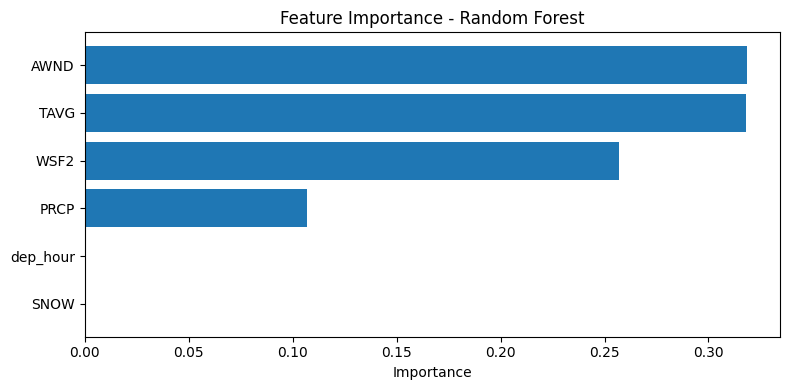

In [36]:
# Step 8: Feature Importance Plot

plt.figure(figsize=(8, 4))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Step 9: Conclusion
- Both models provide useful results; Random Forest slightly outperforms Logistic Regression.
- Most influential features include wind speed (AWND), gust speed (WSF2), and average temperature (TAVG).
- This classification model predicts whether a flight is likely to be delayed based on scheduled hour and weather.